In [1]:
# Libraries
import pandas as pd
import numpy as np
import re
import spacy
import joblib
from sklearn.ensemble import GradientBoostingClassifier
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import torch
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
import nltk
from nltk.corpus import stopwords
from umap import UMAP
from collections import Counter
from nltk.stem import WordNetLemmatizer
from collections import defaultdict
from transformers import AutoTokenizer
from symspellpy import SymSpell, Verbosity
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer, util
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [2]:
# Loading the dataset
costco_insta_corpus = pd.read_csv('Costco_Finder_data_2022_2025.csv')

In [3]:
# Dataset
costco_insta_corpus.head(10)

,short_code,post_title,post_likes,post_year,post_month,comments,comment_like,reply_count,comment_year,comment_month
0,CsAJLJhAPmN,💦 It’s a misting fan at Costco!!! This one is ...,35807,2023,5,It was just a wet mess for us.,0.0,0.0,2023.0,7.0
1,CsAJLJhAPmN,💦 It’s a misting fan at Costco!!! This one is ...,35807,2023,5,Costco is overrated. Sams is better. Cheaper ...,0.0,0.0,2023.0,7.0
2,CsAJLJhAPmN,💦 It’s a misting fan at Costco!!! This one is ...,35807,2023,5,We purchased one and we love it.,0.0,0.0,2023.0,7.0
3,CsAJLJhAPmN,💦 It’s a misting fan at Costco!!! This one is ...,35807,2023,5,@michelle_n122,0.0,1.0,2023.0,7.0
4,CsAJLJhAPmN,💦 It’s a misting fan at Costco!!! This one is ...,35807,2023,5,Would be better battery operated,0.0,0.0,2023.0,7.0
5,CsAJLJhAPmN,💦 It’s a misting fan at Costco!!! This one is ...,35807,2023,5,@una_nah,1.0,0.0,2023.0,7.0
6,CsAJLJhAPmN,💦 It’s a misting fan at Costco!!! This one is ...,35807,2023,5,We bought it and have to return. It releases t...,0.0,0.0,2023.0,7.0
7,CsAJLJhAPmN,💦 It’s a misting fan at Costco!!! This one is ...,35807,2023,5,😂😮I love mine I have it on my back patio,0.0,0.0,2023.0,7.0
8,CsAJLJhAPmN,💦 It’s a misting fan at Costco!!! This one is ...,35807,2023,5,@juniorelchihuas to take to the games lol,1.0,1.0,2023.0,7.0
9,CsAJLJhAPmN,💦 It’s a misting fan at Costco!!! This one is ...,35807,2023,5,@aka_thedestroyer,0.0,0.0,2023.0,7.0


In [4]:
# Lets rename the columns to match other dataset formats
rename_columns = ['url_code', 'post_title', 'post_likes', 'post_year', 'post_month', 'comments', 'comment_like', 'reply_count', 'comment_year', 'comment_month']
costco_insta_corpus.columns = rename_columns

# Adding a tag for the source of data 
costco_insta_corpus[['source']] = 'instagram'
pd.options.display.float_format = '{:.0f}'.format

# Reseting the index
costco_insta_corpus.index = np.arange(1, len(costco_insta_corpus)+1)

In [5]:
costco_insta_corpus

,url_code,post_title,post_likes,post_year,post_month,comments,comment_like,reply_count,comment_year,comment_month,source
1,CsAJLJhAPmN,💦 It’s a misting fan at Costco!!! This one is ...,35807,2023,5,It was just a wet mess for us.,0,0,2023,7,instagram
2,CsAJLJhAPmN,💦 It’s a misting fan at Costco!!! This one is ...,35807,2023,5,Costco is overrated. Sams is better. Cheaper ...,0,0,2023,7,instagram
3,CsAJLJhAPmN,💦 It’s a misting fan at Costco!!! This one is ...,35807,2023,5,We purchased one and we love it.,0,0,2023,7,instagram
4,CsAJLJhAPmN,💦 It’s a misting fan at Costco!!! This one is ...,35807,2023,5,@michelle_n122,0,1,2023,7,instagram
5,CsAJLJhAPmN,💦 It’s a misting fan at Costco!!! This one is ...,35807,2023,5,Would be better battery operated,0,0,2023,7,instagram
...,...,...,...,...,...,...,...,...,...,...,...
81241,C6wNBQ6ugGA,👀 85” @SonyElectronics BRAVIA X80CK 4K LED TV ...,24358,2024,5,Bought the 75” Hisense for $499 love it 🤣,0,0,2024,5,instagram
81242,C6wNBQ6ugGA,👀 85” @SonyElectronics BRAVIA X80CK 4K LED TV ...,24358,2024,5,Vizio gang,0,0,2024,5,instagram
81243,C6wNBQ6ugGA,👀 85” @SonyElectronics BRAVIA X80CK 4K LED TV ...,24358,2024,5,Sold TVs for 15 years. DO NOT buy this tv. It ...,0,0,2024,5,instagram
81244,C6wNBQ6ugGA,👀 85” @SonyElectronics BRAVIA X80CK 4K LED TV ...,24358,2024,5,Walmarts $210 65” TV works just fine 👏,0,0,2024,5,instagram


In [6]:
# Information about the corpus
costco_insta_corpus.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81245 entries, 1 to 81245
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   url_code       81245 non-null  object 
 1   post_title     81245 non-null  object 
 2   post_likes     81245 non-null  int64  
 3   post_year      81245 non-null  int64  
 4   post_month     81245 non-null  int64  
 5   comments       80849 non-null  object 
 6   comment_like   81244 non-null  float64
 7   reply_count    81244 non-null  float64
 8   comment_year   81244 non-null  float64
 9   comment_month  81244 non-null  float64
 10  source         81245 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 7.1+ MB


In [7]:
# Analyzing missing values
costco_insta_corpus.isnull().sum()

url_code           0
post_title         0
post_likes         0
post_year          0
post_month         0
comments         396
comment_like       1
reply_count        1
comment_year       1
comment_month      1
source             0
dtype: int64

In [8]:
# Next, we will look for 'comment_like' column
# Checking rows with missing 'comment_like'
missing_post_title_rows = costco_insta_corpus[costco_insta_corpus['comment_like'].isna()]

# Checking unique 'url_code' for rows with missing 'comment_like'
unique_url_codes = missing_post_title_rows['url_code'].unique()

# Displaying unique url codes
print(unique_url_codes)

['CpDZlVDjYSR']


In [9]:
costco_insta_corpus[costco_insta_corpus['url_code'].isin(unique_url_codes)]

,url_code,post_title,post_likes,post_year,post_month,comments,comment_like,reply_count,comment_year,comment_month,source
9305,CpDZlVDjYSR,🚴 Bike Shorts at Costco in a 2-pack!!! They ha...,40386,2023,2,NaN,NaN,NaN,NaN,NaN,instagram


In [10]:
# Drop the specific row with url_code 'CpDZlVDjYSR'
costco_insta_corpus = costco_insta_corpus[costco_insta_corpus['url_code'] != 'CpDZlVDjYSR']

In [11]:
# Now, let's again analyze missing values
costco_insta_corpus.isnull().sum()

url_code           0
post_title         0
post_likes         0
post_year          0
post_month         0
comments         395
comment_like       0
reply_count        0
comment_year       0
comment_month      0
source             0
dtype: int64

In [12]:
# lastly, we will look at comments
# Checking rows with missing 'comments'
missing_post_title_rows = costco_insta_corpus[costco_insta_corpus['comments'].isna()]

# Checking unique 'url_code' for rows with missing 'comments'
unique_url_codes = missing_post_title_rows['url_code'].unique()

# Displaying unique url codes
print(unique_url_codes)

['CsAJLJhAPmN' 'CrmXPnCMrXj' 'CrhApZ-uayE' 'CqLhoIhDrul' 'CpscThVjYLO'
 'Cpd_ZR9jQGS' 'DAghffkO9lE' 'C9LRV9khxW9' 'C8DW85hhlLM' 'C77i8BlBnOt'
 'C8KYt1nunBv' 'C7h1OLKuX9Q' 'C7zKEMiOLCO' 'C7Hff-rO1ba' 'C7P1U4cOvaR'
 'C7C9u_nuPC9' 'C66dm7vu5FI' 'C69ctkSOKHj' 'C64pTo3ufl8' 'C6ojYmaO1zr'
 'C6yuKYYOQB2' 'C6e7PERORRS' 'C6G9LfrO1dN' 'C59dzZ_OOgW' 'C5_TuSHOXEP'
 'C51s8RJOE9Q' 'C5zHRCBO25o' 'C56NQWDuUVo' 'C5mQG9ZOmxW' 'C5W1t4uuZmJ'
 'C5JiHnzuMG5' 'C5bQB78unjk' 'C5tVf_UOzJP' 'C5WH2NluXKb' 'C43Pu27uYZ8'
 'C5CTlEvO982' 'C41TMcfOvtd' 'C4oe0s5OtHr' 'C4ZG6WBvSBc' 'C4lQWWLOFcm'
 'C5HWs6Ou3Mv' 'C4eOzkBv_Ur' 'C4YNOSxRR42' 'C4rPVp7OfSG' 'C4JsmrguRsr'
 'C4O3qQsuHCi' 'C4HFhV2OLl6' 'C4LeAtzOJBl' 'C4BM26Bu1Hp' 'C4OE746uEm3'
 'C3qutzhO8pk' 'C3yjyd3O3uk' 'C31EBYFOBBW' 'C3v9UxWObvC' 'C3840iZuTzi'
 'C3vPEzmu-im' 'C3IjfB0O47L' 'C3akWvMuTjn' 'C3lpVkWOfbl' 'C3gMS43ubui'
 'C252c11O1Ae' 'C23RknrOF2D' 'C2aNGgOuUMF' 'C2QtcH2uh5-' 'C2is1EYOESU'
 'C2P3MNvuKlg' 'C2OKQlguim6' 'C10bSWWOthV' 'C14y128OrYZ' 'C18CE7RuSvI'
 'C1Zy

In [13]:
# Now fill missing comments as the urls have NAN comments (comments in gifs)
costco_insta_corpus['comments'].fillna('[comment in gif format]', inplace=True)

# Check for remaining null values
costco_insta_corpus.isnull().sum()

url_code         0
post_title       0
post_likes       0
post_year        0
post_month       0
comments         0
comment_like     0
reply_count      0
comment_year     0
comment_month    0
source           0
dtype: int64

In [14]:
costco_insta_corpus.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81244 entries, 1 to 81245
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   url_code       81244 non-null  object 
 1   post_title     81244 non-null  object 
 2   post_likes     81244 non-null  int64  
 3   post_year      81244 non-null  int64  
 4   post_month     81244 non-null  int64  
 5   comments       81244 non-null  object 
 6   comment_like   81244 non-null  float64
 7   reply_count    81244 non-null  float64
 8   comment_year   81244 non-null  float64
 9   comment_month  81244 non-null  float64
 10  source         81244 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 7.1+ MB


In [15]:
# Reseting the index
costco_insta_corpus.index = np.arange(1, len(costco_insta_corpus)+1)

In [16]:
costco_insta_corpus.head(10)

,url_code,post_title,post_likes,post_year,post_month,comments,comment_like,reply_count,comment_year,comment_month,source
1,CsAJLJhAPmN,💦 It’s a misting fan at Costco!!! This one is ...,35807,2023,5,It was just a wet mess for us.,0,0,2023,7,instagram
2,CsAJLJhAPmN,💦 It’s a misting fan at Costco!!! This one is ...,35807,2023,5,Costco is overrated. Sams is better. Cheaper ...,0,0,2023,7,instagram
3,CsAJLJhAPmN,💦 It’s a misting fan at Costco!!! This one is ...,35807,2023,5,We purchased one and we love it.,0,0,2023,7,instagram
4,CsAJLJhAPmN,💦 It’s a misting fan at Costco!!! This one is ...,35807,2023,5,@michelle_n122,0,1,2023,7,instagram
5,CsAJLJhAPmN,💦 It’s a misting fan at Costco!!! This one is ...,35807,2023,5,Would be better battery operated,0,0,2023,7,instagram
6,CsAJLJhAPmN,💦 It’s a misting fan at Costco!!! This one is ...,35807,2023,5,@una_nah,1,0,2023,7,instagram
7,CsAJLJhAPmN,💦 It’s a misting fan at Costco!!! This one is ...,35807,2023,5,We bought it and have to return. It releases t...,0,0,2023,7,instagram
8,CsAJLJhAPmN,💦 It’s a misting fan at Costco!!! This one is ...,35807,2023,5,😂😮I love mine I have it on my back patio,0,0,2023,7,instagram
9,CsAJLJhAPmN,💦 It’s a misting fan at Costco!!! This one is ...,35807,2023,5,@juniorelchihuas to take to the games lol,1,1,2023,7,instagram
10,CsAJLJhAPmN,💦 It’s a misting fan at Costco!!! This one is ...,35807,2023,5,@aka_thedestroyer,0,0,2023,7,instagram


## Phase 1:- Lexical and Morphological Analysis

Lexical Analysis includes the following sub phases: 
   - 1. Lowercasing of the text (in our case the comments and post captions)
   - 2. Removal of special characters
   - 3. Tokenization
   - 4. Stopword removal
   - 5. Lemmatization
   - 6. Spelling Correction

Morphological Analysis includes morphemes that are fundamental building blocks of words, carrying meaning that cannot be further divided.
Two Types :
   - 1. Free Morphemes: These can stand alone as complete words, such as "book" or "happy."
   - 2. Bound Morphemes: These cannot exist independently and must attach to a free morpheme, like prefixes (e.g., "un-" in "unlock") or suffixes (e.g., "-ing" in "running").

Understanding morphemes helps in analyzing word formation and linguistic structures.

In [17]:
# 1. Lowercasing
costco_insta_corpus['post_title'] = costco_insta_corpus['post_title'].str.lower()
costco_insta_corpus['comments'] = costco_insta_corpus['comments'].str.lower()

# 2. Remove usernames except @costco and blank out comments that only had usernames
costco_insta_corpus['comments'] = costco_insta_corpus['comments'].apply(
    lambda x: "" if isinstance(x, str) and re.fullmatch(r'@\w+', x) and x != "@costco"
    else re.sub(r'@(?!costco\b)\w+', '', x) if isinstance(x, str) else x
)

# 3. Remove nulls and empty strings in 'comments'
costco_insta_corpus = costco_insta_corpus[
    costco_insta_corpus['comments'].notnull() & (costco_insta_corpus['comments'].str.strip() != "")
]

# 4. Reindex after cleanup
costco_insta_corpus.reset_index(drop=True, inplace=True)
costco_insta_corpus.index += 1  # Start indexing from 1

In [18]:
print(costco_insta_corpus.iloc[4]['post_title'], "\n")
print(costco_insta_corpus.iloc[4]['comments'])

💦 it’s a misting fan at costco!!! this one is portable so it’s not only great for patios but you could take it with you camping or to any outdoor activities. super cool!

.

#costco #summermusthave #reels 

we bought it and have to return. it releases too much mist that can make u soak. the mist runs continuously.


In [19]:
# 2. Removal of special characters
# Pattern to keep letters, numbers, spaces, and selected emojis/symbols
pattern = r"[^a-zA-Z0-9.,!?$&@#'’%:;()\-\[\]{}\"✔✖❌❤️🔥💯😊👍💪\U0001F000-\U0001FFFF]"

# Remove unwanted characters from 'post_title'
costco_insta_corpus['post_title'] = costco_insta_corpus['post_title'].apply(
    lambda x: re.sub(pattern, ' ', x) if isinstance(x, str) else x
)

# Remove unwanted characters from 'comments'
costco_insta_corpus['comments'] = costco_insta_corpus['comments'].apply(
    lambda x: re.sub(pattern, ' ', x) if isinstance(x, str) else x
)

In [20]:
print(costco_insta_corpus.iloc[4]['post_title'])
print(costco_insta_corpus.iloc[4]['comments'])

💦 it’s a misting fan at costco!!! this one is portable so it’s not only great for patios but you could take it with you camping or to any outdoor activities. super cool!  .  #costco #summermusthave #reels
we bought it and have to return. it releases too much mist that can make u soak. the mist runs continuously.


In [21]:
# Load a tokenizer specifically trained for social media text (emoji support)
bert_tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=True)

### 🔹 **Function: Merging Subword Tokens**
def merge_subwords(tokens):
    """Properly merge BERT subwords that were split with '@@'."""
    merged_tokens = []
    buffer = ""
    
    for token in tokens:
        if token.endswith("@@"):
            buffer += token.replace("@@", "")  # Remove "@@" and store in buffer
        else:
            if buffer:  # If buffer has accumulated subword parts, merge them
                merged_tokens.append(buffer + token)
                buffer = ""  # Reset buffer
            else:
                merged_tokens.append(token)

    return merged_tokens

### 🔹 **Function: Tokenizing Text with BERT**
def tokenize_text(text):
    """Tokenizes text using BERTweet, merges subwords, and returns tokenized words."""
    if isinstance(text, str):
        tokens = bert_tokenizer.tokenize(text)
        return merge_subwords(tokens)
    return []

### 🔹 **Function: Convert Tokens to BERT Numerical IDs**
def get_bert_numerical_tokens(tokens):
    """Convert a list of tokens into numerical BERT token IDs."""
    if isinstance(tokens, list) and len(tokens) > 0:
        encoded = bert_tokenizer(tokens, is_split_into_words=True, padding=True, truncation=True, return_tensors="pt")
        return encoded['input_ids'].squeeze().tolist()
    return []

In [22]:
# Apply BERT tokenizer to 'post_title' and 'comments'
costco_insta_corpus['post_title_tokens'] = costco_insta_corpus['post_title'].apply(tokenize_text)
costco_insta_corpus['comments_tokens'] = costco_insta_corpus['comments'].apply(tokenize_text)

# Convert tokens into numerical format (IDs)
costco_insta_corpus['post_title_numerical_tokens'] = costco_insta_corpus['post_title_tokens'].apply(get_bert_numerical_tokens)
costco_insta_corpus['comments_numerical_tokens'] = costco_insta_corpus['comments_tokens'].apply(get_bert_numerical_tokens)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [23]:
print(costco_insta_corpus.iloc[4]['post_title_tokens'], '\n')
print(costco_insta_corpus.iloc[4]['comments_tokens'])

['💦', 'it’s', 'a', 'misting', 'fan', 'at', 'costco!!!', 'this', 'one', 'is', 'portable', 'so', 'it’s', 'not', 'only', 'great', 'for', 'patios', 'but', 'you', 'could', 'take', 'it', 'with', 'you', 'camping', 'or', 'to', 'any', 'outdoor', 'activities.', 'super', 'cool!', '.', '#costco', '#summermusthave', '#reels'] 

['we', 'bought', 'it', 'and', 'have', 'to', 'return.', 'it', 'releases', 'too', 'much', 'mist', 'that', 'can', 'make', 'u', 'soak.', 'the', 'mist', 'runs', 'continuously.']


In [24]:
print(costco_insta_corpus.iloc[4]['post_title_numerical_tokens'], '\n')
print(costco_insta_corpus.iloc[4]['comments_numerical_tokens'])

[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 31359, 1356, 41407, 41407, 12, 33, 63, 17, 23862, 39, 987, 3, 256, 46, 121, 200, 19, 38292, 1765, 42, 14, 152, 169, 18, 30, 14, 12136, 72, 9, 207, 11649, 29389, 46257, 4, 1068, 29055, 12, 4, 7117, 1061, 2640, 19796, 9362, 14185, 1988, 5893, 3141, 2] 

[0, 54, 1201, 18, 13, 36, 9, 507, 16188, 4, 18, 7651, 111, 112, 20715, 25, 56, 115, 79, 2266, 1901, 4, 6, 20715, 2465, 40548, 5301, 1747, 4, 2]


In [25]:
# Load SpaCy and disable unnecessary components for speed
nlp = spacy.load("en_core_web_lg") 

# Set of all stopwords in lowercase + common contractions
custom_stopwords = nlp.Defaults.stop_words.union({
    "i've", "you've", "we've", "they've",
    "i'm", "you're", "we're", "they're",
    "i'll", "you'll", "he'll", "she'll", "we'll", "they'll",
    "i'd", "you'd", "he'd", "she'd", "we'd", "they'd",
    "isn't", "aren't", "wasn't", "weren't", "hasn't", "haven't",
    "hadn't", "doesn't", "don't", "didn't", "won't", "wouldn't",
    "shan't", "shouldn't", "can't", "cannot", "couldn't", "mustn't",
    "let's", "that's", "who's", "what's", "here's", "there's", "where's",
    "when's", "why's", "how's", "u", "a"
})

# Function to filter stopwords using spaCy’s nlp.pipe() for speed
def remove_stopwords_batch(text_series):
    return [
        [token.text for token in doc if token.text.lower() not in custom_stopwords and not token.is_punct]
        for doc in nlp.pipe(text_series.astype(str), batch_size=1000, n_process=-1)
    ]

# Apply to your corpus
costco_insta_corpus['post_title_tokens'] = remove_stopwords_batch(costco_insta_corpus['post_title'])
costco_insta_corpus['comments_tokens'] = remove_stopwords_batch(costco_insta_corpus['comments'])

In [26]:
print(costco_insta_corpus.iloc[4]['post_title_tokens'], '\n')
print(costco_insta_corpus.iloc[4]['comments_tokens'])

['💦', 'misting', 'fan', 'costco', 'portable', 'great', 'patios', 'camping', 'outdoor', 'activities', 'super', 'cool', ' ', ' ', 'costco', 'summermusthave', 'reels'] 

['bought', 'return', 'releases', 'mist', 'soak', 'mist', 'runs', 'continuously']


In [27]:
# Load only the tagger and lemmatizer for performance
nlp = spacy.load("en_core_web_lg") 

# Lemmatization via spaCy
def spacy_batch_lemmatize(texts):
    lemmatized = []
    for doc in nlp.pipe(texts, batch_size=1000, n_process=-1):
        lemmatized.append([token.lemma_ for token in doc if token.lemma_ != "-PRON-"])
    return lemmatized

# First join tokens back to strings (if already tokenized)
post_texts = costco_insta_corpus['post_title_tokens'].apply(lambda tokens: " ".join(tokens))
comment_texts = costco_insta_corpus['comments_tokens'].apply(lambda tokens: " ".join(tokens))

# Then lemmatize
costco_insta_corpus['post_title_tokens'] = spacy_batch_lemmatize(post_texts.tolist())
costco_insta_corpus['comments_tokens'] = spacy_batch_lemmatize(comment_texts.tolist())

In [28]:
print(costco_insta_corpus.iloc[4]['post_title_tokens'], '\n')
print(costco_insta_corpus.iloc[4]['comments_tokens'])

['💦', 'mist', 'fan', 'costco', 'portable', 'great', 'patio', 'camping', 'outdoor', 'activity', 'super', 'cool', '    ', 'costco', 'summermusthave', 'reel'] 

['buy', 'return', 'release', 'mist', 'soak', 'mist', 'run', 'continuously']


In [29]:
#5. Spell-Correcter

# Initialize SymSpell
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)

# Load dictionary file (Ensure the file is in your working directory)
dictionary_path = "frequency_dictionary_en_82_765.txt"
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

# Function for spelling correction using SymSpell
def correct_spelling(tokens):
    return [sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)[0].term if word.isalpha() and 
            sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2) else word for word in tokens]

In [30]:
# Apply spelling correction to 'post_title_tokens' and 'comments_tokens'
costco_insta_corpus['post_title_tokens'] = costco_insta_corpus['post_title_tokens'].apply(correct_spelling)
costco_insta_corpus['comments_tokens'] = costco_insta_corpus['comments_tokens'].apply(correct_spelling)

In [31]:
print(costco_insta_corpus.iloc[4]['post_title_tokens'], '\n')
print(costco_insta_corpus.iloc[4]['comments_tokens'])

['💦', 'mist', 'fan', 'costco', 'portable', 'great', 'patio', 'camping', 'outdoor', 'activity', 'super', 'cool', '    ', 'costco', 'summermusthave', 'reel'] 

['buy', 'return', 'release', 'mist', 'soak', 'mist', 'run', 'continuously']


In [32]:
costco_insta_corpus

,url_code,post_title,post_likes,post_year,post_month,comments,comment_like,reply_count,comment_year,comment_month,source,post_title_tokens,comments_tokens,post_title_numerical_tokens,comments_numerical_tokens
1,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,it was just a wet mess for us.,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[wet, mess]","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 18, 38, 45, 11, 3523, 1920, 19, 1924, 4, 2]"
2,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,costco is overrated. sams is better. cheaper ...,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[costco, overrate, , sam, well, cheap, well,...","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 31359, 2640, 17, 1824, 10573, 1250, 4, 423..."
3,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,we purchased one and we love it.,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[purchase, love]","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 54, 8538, 63, 13, 54, 71, 987, 4, 2]"
4,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,would be better battery operated,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[well, battery, operate]","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 86, 31, 178, 5390, 11651, 2]"
5,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,we bought it and have to return. it releases t...,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[buy, return, release, mist, soak, mist, run, ...","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 54, 1201, 18, 13, 36, 9, 507, 16188, 4, 18..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69058,C6wNBQ6ugGA,👀 85 @sonyelectronics bravia x80ck 4k led tv ...,24358,2024,5,bought the 75 hisense for $499 love it 🤣,0,0,2024,5,instagram,"[👀, 85, , @sonyelectronics, brain, x80ck, 4k...","[buy, 75, , license, $, 499, love, 🤣]","[0, 3, 4191, 5238, 3303, 22293, 1505, 2475, 33...","[0, 1201, 6, 2251, 16570, 13048, 19, 3, 42128,..."
69059,C6wNBQ6ugGA,👀 85 @sonyelectronics bravia x80ck 4k led tv ...,24358,2024,5,vizio gang,0,0,2024,5,instagram,"[👀, 85, , @sonyelectronics, brain, x80ck, 4k...","[video, gang]","[0, 3, 4191, 5238, 3303, 22293, 1505, 2475, 33...","[0, 2358, 30256, 4886, 2]"
69060,C6wNBQ6ugGA,👀 85 @sonyelectronics bravia x80ck 4k led tv ...,24358,2024,5,sold tvs for 15 years. do not buy this tv. it ...,0,0,2024,5,instagram,"[👀, 85, , @sonyelectronics, brain, x80ck, 4k...","[sell, to, 15, year, buy, to, horrible]","[0, 3, 4191, 5238, 3303, 22293, 1505, 2475, 33...","[0, 2104, 543, 808, 19, 532, 11186, 32188, 32,..."
69061,C6wNBQ6ugGA,👀 85 @sonyelectronics bravia x80ck 4k led tv ...,24358,2024,5,walmarts $210 65 tv works just fine 👏,0,0,2024,5,instagram,"[👀, 85, , @sonyelectronics, brain, x80ck, 4k...","[walmart, $, 210, 65, , to, work, fine, 👏]","[0, 3, 4191, 5238, 3303, 22293, 1505, 2475, 33...","[0, 5400, 2350, 1031, 3, 20141, 2913, 1513, 10..."


## Explortory Data Analysis

### Word Frequency Analysis

In [33]:
# Function to keep only words (remove punctuation, emojis, Unicode symbols, numbers, spaces, and apostrophes)
def filter_words_only(tokens):
    return [word.strip() for word in tokens if re.match(r'^[a-zA-Z]+$', word)]  # Keep only alphabetic words

# Get words-only list for visualization (word cloud & frequency) - without modifying dataset
filtered_post_words = [word for tokens in costco_insta_corpus['post_title_tokens'] for word in filter_words_only(tokens)]
filtered_comment_words = [word for tokens in costco_insta_corpus['comments_tokens'] for word in filter_words_only(tokens)]

# Count word frequencies (only words)
filtered_post_word_freq = Counter(filtered_post_words)
filtered_comment_word_freq = Counter(filtered_comment_words)

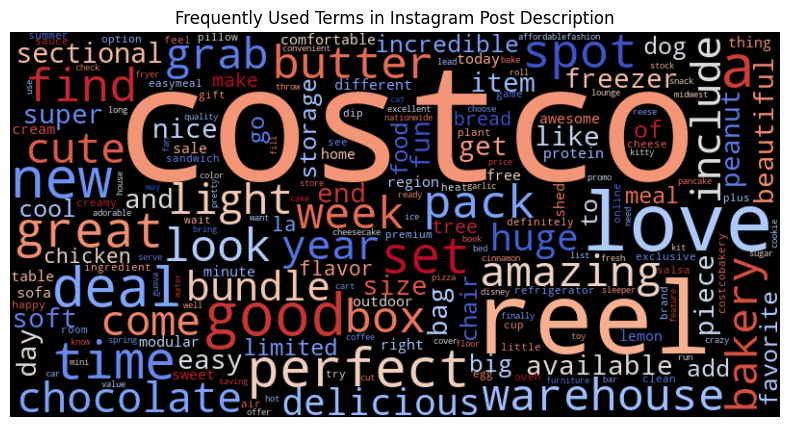

In [34]:
# Generate Word Clouds (excluding punctuation)
filtered_post_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='coolwarm').generate_from_frequencies(filtered_post_word_freq)
filtered_comment_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='coolwarm').generate_from_frequencies(filtered_comment_word_freq)

# Plot Word Cloud for Post Titles (Without Punctuation)
plt.figure(figsize=(10, 5))
plt.imshow(filtered_post_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Frequently Used Terms in Instagram Post Description")
plt.show()

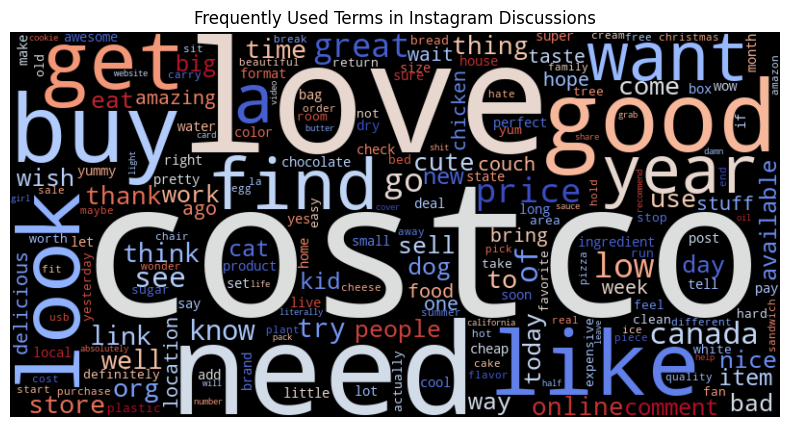

In [35]:
# Plot Word Cloud for Comments (Without Punctuation)
plt.figure(figsize=(10, 5))
plt.imshow(filtered_comment_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Frequently Used Terms in Instagram Discussions")
plt.show()

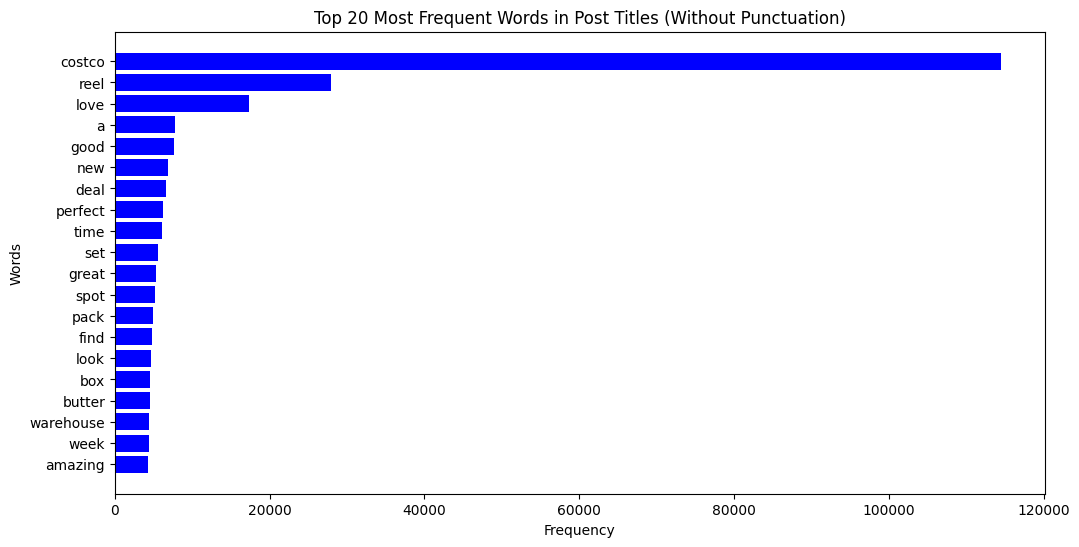

In [36]:
# Bar chart for top 20 frequent words in post titles (without punctuation)
top_filtered_post_words = filtered_post_word_freq.most_common(20)
top_filtered_post_words_df = pd.DataFrame(top_filtered_post_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(12, 6))
plt.barh(top_filtered_post_words_df['Word'], top_filtered_post_words_df['Frequency'], color='blue')
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Most Frequent Words in Post Titles (Without Punctuation)")
plt.gca().invert_yaxis()
plt.show()

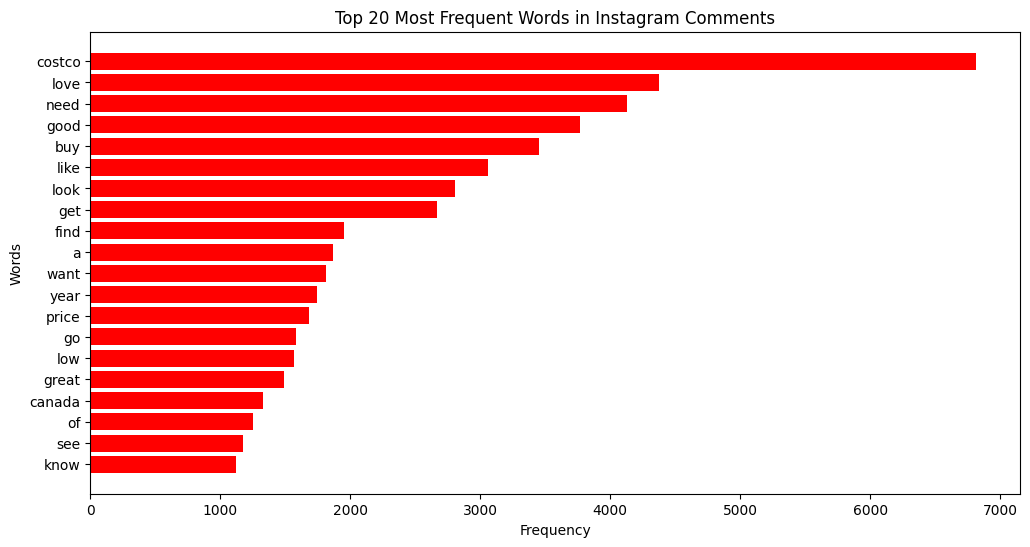

In [37]:
# Bar chart for top 20 frequent words in comments (without punctuation)
top_filtered_comment_words = filtered_comment_word_freq.most_common(20)
top_filtered_comment_words_df = pd.DataFrame(top_filtered_comment_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(12, 6))
plt.barh(top_filtered_comment_words_df['Word'], top_filtered_comment_words_df['Frequency'], color='red')
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.title("Top 20 Most Frequent Words in Instagram Comments")
plt.gca().invert_yaxis()
plt.show()

### Monthly & Yearly Trends in Comments and Posts

Yearly Unique Post Counts:
 post_year
2022     59
2023    217
2024    471
2025    137
Name: url_code, dtype: int64

Total Number of Unique Posts in Dataset: 884


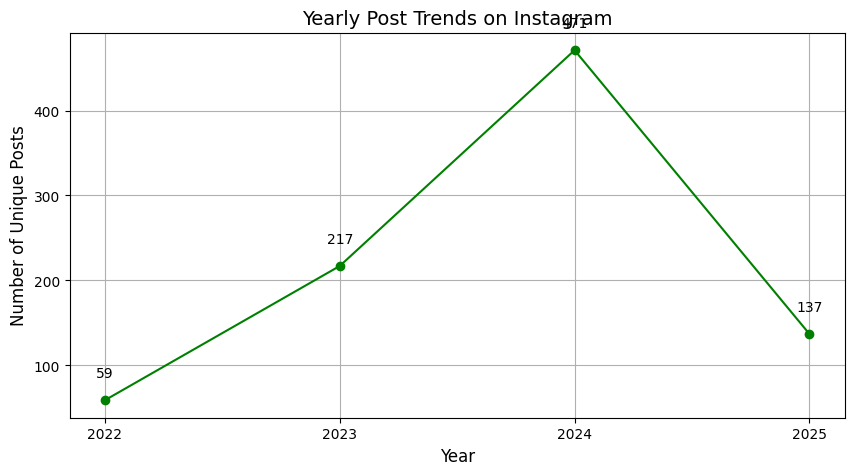

In [38]:
##  Post Trends

# Ensure 'post_year' column is in integer format
costco_insta_corpus['post_year'] = costco_insta_corpus['post_year'].astype(int)

# Count unique posts per year
yearly_posts = costco_insta_corpus.groupby('post_year')['url_code'].nunique()

# Display yearly unique post counts
print("Yearly Unique Post Counts:\n", yearly_posts)

# Calculate total number of unique posts
total_posts = yearly_posts.sum()
print("\nTotal Number of Unique Posts in Dataset:", total_posts)

# **Plot Yearly Post Trends**
plt.figure(figsize=(10, 5))
plt.plot(yearly_posts.index, yearly_posts.values, marker='o', color='g', linestyle='-')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Unique Posts', fontsize=12)
plt.title('Yearly Post Trends on Instagram', fontsize=14)
plt.grid(True)
plt.xticks(yearly_posts.index, fontsize=10)  # Ensure all years are labeled

# Annotate each year with its post count (offset upward for visibility)
for year, count in zip(yearly_posts.index, yearly_posts.values):
    plt.text(year, count + (0.05 * max(yearly_posts.values)), f'{count}', 
             fontsize=10, ha='center', va='bottom', color='black')

plt.show()

In [39]:
## Comment Trends

# Ensure 'comment_year' column is in integer format
costco_insta_corpus['comment_year'] = costco_insta_corpus['comment_year'].astype(int)

# Group by year to count total comments
yearly_comments = costco_insta_corpus.groupby('comment_year').size()

# Display yearly comment counts
print("Yearly Comment Counts:")
print(yearly_comments)

Yearly Comment Counts:
comment_year
2022     2924
2023    16847
2024    38152
2025    11139
dtype: int64


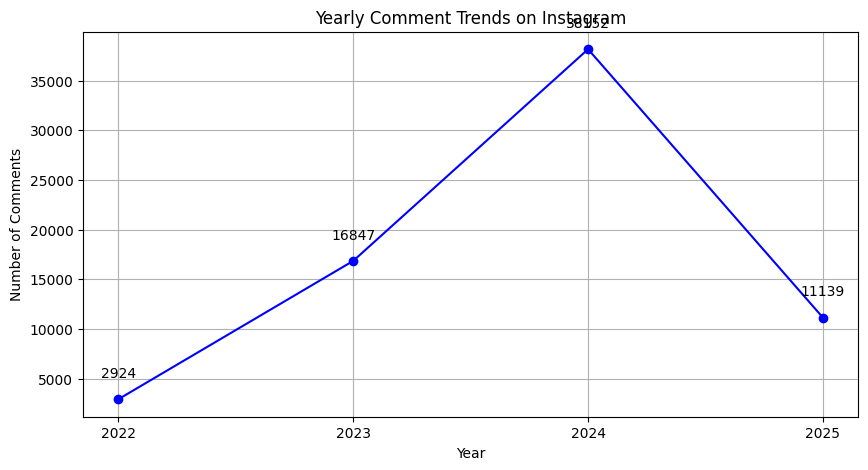

In [40]:
# Sort the index to maintain chronological order
yearly_comments = yearly_comments.sort_index()

# Plot yearly comment trends
plt.figure(figsize=(10, 5))
plt.plot(yearly_comments.index, yearly_comments.values, marker='o', color='b', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Number of Comments')
plt.title('Yearly Comment Trends on Instagram')
plt.grid(True)
plt.xticks(yearly_comments.index)  # Ensure all years are labeled

# Annotate each year with its comment count (offset upward for visibility)
for year, count in zip(yearly_comments.index, yearly_comments.values):
    plt.text(year, count + (0.05 * max(yearly_comments.values)),  # Slightly above point
             f'{count}', fontsize=10, ha='center', va='bottom', color='black')
plt.show()

Monthly Unique Post Counts:
 post_year   2022  2023  2024  2025
post_month                        
1              0    41    40    43
2              0    33    38    35
3              0    38    39    42
4              0    31    40    17
5              0    15    35     0
6              0     0    37     0
7              0     0    40     0
8              0     0    41     0
9              0     0    43     0
10             0     0    41     0
11            19    24    43     0
12            40    35    34     0


<Figure size 1200x600 with 0 Axes>

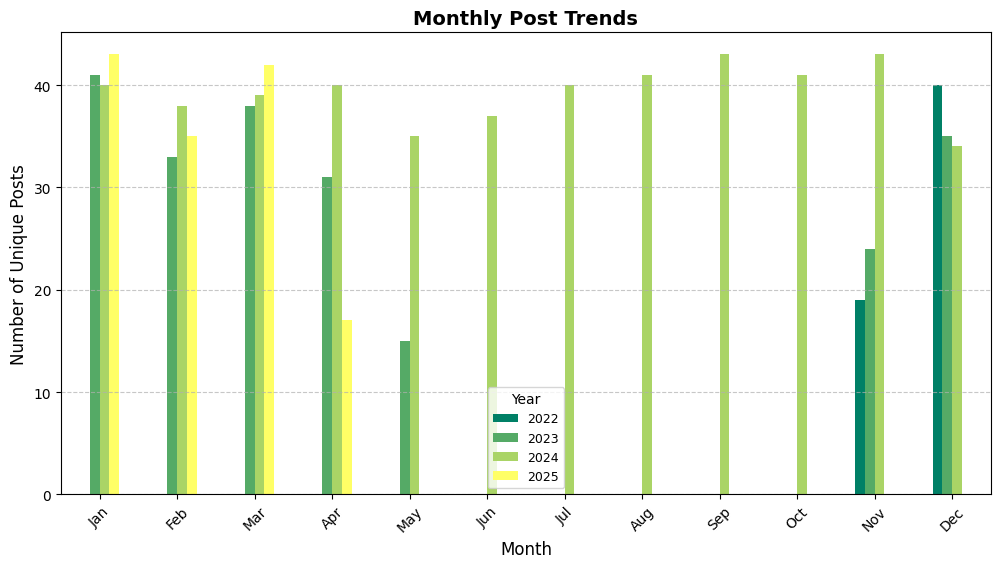

In [41]:
## **Monthly Unique Post Trends**
# Ensure 'post_year' and 'post_month' columns are in integer format
costco_insta_corpus['post_year'] = costco_insta_corpus['post_year'].astype(int)
costco_insta_corpus['post_month'] = costco_insta_corpus['post_month'].astype(int)

# Count unique posts per month
monthly_posts = costco_insta_corpus.groupby(['post_year', 'post_month'])['url_code'].nunique()

# Convert to DataFrame & fill NaN with 0
monthly_posts_df = monthly_posts.reset_index().pivot(index='post_month', columns='post_year', values='url_code').fillna(0)

# Display monthly post counts
print("Monthly Unique Post Counts:\n", monthly_posts_df)

# **Plot Monthly Post Trends**
plt.figure(figsize=(12, 6))
monthly_posts_df.plot(kind='bar', figsize=(12, 6), colormap='summer')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Unique Posts', fontsize=12)
plt.title('Monthly Post Trends', fontsize=14, fontweight='bold')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.legend(title='Year', fontsize=9)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [42]:
## **Monthly Comment Trends**
# Ensure 'comment_year' and 'comment_month' columns are in integer format
costco_insta_corpus['comment_year'] = costco_insta_corpus['comment_year'].astype(int)
costco_insta_corpus['comment_month'] = costco_insta_corpus['comment_month'].astype(int)

# Count total comments per month
monthly_comments = costco_insta_corpus.groupby(['comment_year', 'comment_month']).size()

# Convert to DataFrame & fill NaN with 0
monthly_comments_df = monthly_comments.reset_index().pivot(index='comment_month', columns='comment_year', values=0).fillna(0)

# Display monthly comment counts
monthly_comments_df

comment_year,2022,2023,2024,2025
comment_month,,,,
1,0,2988,4124,3269
2,0,2247,3353,2669
3,0,2850,3620,3975
4,0,2630,2898,1226
5,0,1936,3624,0
6,0,547,2317,0
7,0,187,3317,0
8,0,21,4293,0
9,0,8,2966,0


<Figure size 1200x600 with 0 Axes>

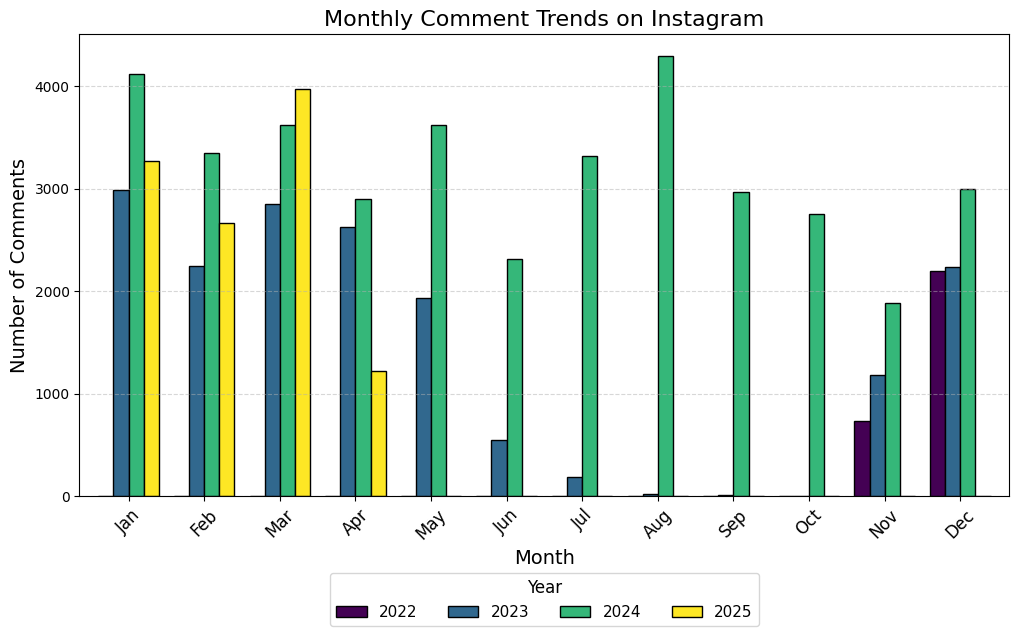

In [43]:
# Plot with improved visualization
plt.figure(figsize=(12, 6))
ax = monthly_comments_df.plot(kind='bar', figsize=(12, 6), colormap='viridis', width=0.8, edgecolor = 'black')

plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Comments', fontsize=14)
plt.title('Monthly Comment Trends on Instagram', fontsize=16)

# Ensure month labels are correctly spaced and readable
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
           rotation=45, fontsize=12)

# Improve legend visibility: Horizontal and placed at the bottom
plt.legend(title='Year', fontsize=11, title_fontsize=12, loc='upper center',
           bbox_to_anchor=(0.5, -0.15), frameon=True, ncol=6)

# Adjust grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

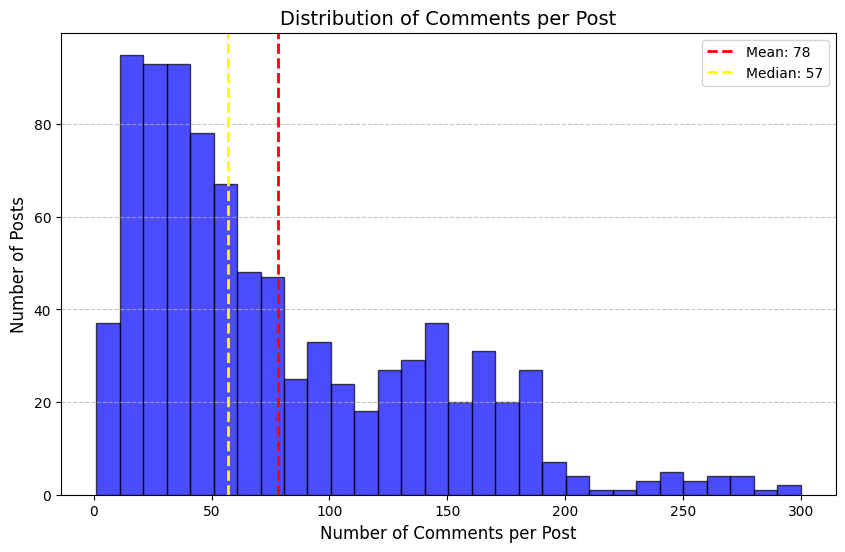

In [44]:
# Count the number of comments per post
comment_distribution = costco_insta_corpus.groupby('url_code')['comments'].count()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(comment_distribution, bins=30, edgecolor='black', alpha=0.7, color='blue')

plt.xlabel("Number of Comments per Post", fontsize=12)
plt.ylabel("Number of Posts", fontsize=12)
plt.title("Distribution of Comments per Post", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate mean and median values
mean_comments = comment_distribution.mean()
median_comments = comment_distribution.median()

plt.axvline(mean_comments, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {int(mean_comments)}')
plt.axvline(median_comments, color='yellow', linestyle='dashed', linewidth=2, label=f'Median: {int(median_comments)}')

plt.legend()
plt.show()

In [45]:
# Find the post with the highest number of comments
most_commented_post = costco_insta_corpus.loc[costco_insta_corpus['comments'].astype(str).str.len().idxmax()]

# Extract the URL code (assuming Instagram URLs follow a standard format)
base_url = "https://www.instagram.com/p/"
most_commented_url = base_url + most_commented_post['url_code']

print("URL of the post with the most comments:", most_commented_url)

URL of the post with the most comments: https://www.instagram.com/p/CnZrw2Cqom9


In [46]:
costco_insta_corpus.head(10)

,url_code,post_title,post_likes,post_year,post_month,comments,comment_like,reply_count,comment_year,comment_month,source,post_title_tokens,comments_tokens,post_title_numerical_tokens,comments_numerical_tokens
1,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,it was just a wet mess for us.,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[wet, mess]","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 18, 38, 45, 11, 3523, 1920, 19, 1924, 4, 2]"
2,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,costco is overrated. sams is better. cheaper ...,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[costco, overrate, , sam, well, cheap, well,...","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 31359, 2640, 17, 1824, 10573, 1250, 4, 423..."
3,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,we purchased one and we love it.,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[purchase, love]","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 54, 8538, 63, 13, 54, 71, 987, 4, 2]"
4,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,would be better battery operated,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[well, battery, operate]","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 86, 31, 178, 5390, 11651, 2]"
5,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,we bought it and have to return. it releases t...,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[buy, return, release, mist, soak, mist, run, ...","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 54, 1201, 18, 13, 36, 9, 507, 16188, 4, 18..."
6,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,😂😮i love mine i have it on my back patio,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[😂, 😮, love, patio]","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 3, 3, 37, 71, 780, 37, 36, 18, 24, 23, 107..."
7,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,to take to the games lol,1,1,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[ , game, low]","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 9, 169, 9, 6, 677, 105, 2]"
8,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,has to be connected to a hose,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[connect, hose]","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 90, 9, 31, 5753, 9, 11, 31948, 2]"
9,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,love mine..❤️❤️ it’s a win for outside parties,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[love, ❤, ️, ❤, ️, win, outside, party]","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 71, 3047, 7174, 639, 3, 3, 3, 3, 987, 3, 2..."
10,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,👏👏👏,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[👏, 👏, 👏]","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 3, 3, 3, 2]"


## Topic Modelling

In [47]:
costco_categories = {
    "Appliances": [
        "Commercial & Restaurant Appliances",
        "Cooking Appliances",
        "Cooktops",
        "Range Hoods",
        "Ranges",
        "Wall Ovens",
        "Dishwashers",
        "Freezers & Ice Makers",
        "Heating, Cooling & Air Quality",
        "Air Conditioners",
        "Air Filters",
        "Air Purifiers",
        "Dehumidifiers",
        "Fans",
        "Humidifiers",
        "Space Heaters",
        "Kitchen Appliance Packages",
        "Electric Kitchen Appliance Packages",
        "Gas Kitchen Appliance Packages",
        "Microwaves",
        "Refrigerators",
        "Bottom Freezer Refrigerators",
        "French Door Refrigerators",
        "Mini Fridges & Compact Refrigerators",
        "Side-By-Side Refrigerators",
        "Top Freezer Refrigerators",
        "Small Kitchen Appliances",
        "Air Fryers",
        "Blenders & Juicers",
        "Coffee Makers & Accessories",
        "Espresso Machines",
        "Mixers & Food Processors",
        "Pressure Cookers & Slow Cookers",
        "Specialty Appliances",
        "Tea Kettles",
        "Toaster Ovens & Toasters",
        "Vacuum Sealers",
        "Water Coolers & Dispensers",
        "Small Space Appliances",
        "Vacuums & Floor Cleaning",
        "Canister Vacuums",
        "Carpet, Steam & Hard Floor Cleaners",
        "Robot Vacuums & Robot Mops",
        "Stick & Handheld Vacuums",
        "Upright Vacuum Cleaners",
        "Wet/Dry & Shop Vacuums",
        "Washers & Dryers",
        "Electric Dryers",
        "Gas Dryers",
        "Laundry Centers",
        "Washer Dryer Combos",
        "Washers & Electric Dryers",
        "Washers & Gas Dryers",
        "Washing Machines",
        "Wine Coolers & Beverage Refrigerators"
    ],
    "Baby": [
        "Baby Care & Safety",
        "Baby Lotions & Creams",
        "Baby Monitors",
        "Bath & Skin Care",
        "Baby Diapers, Wipes & Training Pants",
        "Baby Formula & Feeding",
        "Toddler Food",
        "Car & Booster Seats",
        "Nursery & Baby Furniture"
    ],
    "Beauty": [
        "Bath & Body",
        "Beauty Gift Sets",
        "Beauty Supplements",
        "Beauty Tools & Accessories",
        "Fragrances",
        "Hair Care",
        "Hair Growth Products",
        "Hair Treatments & Styling Products",
        "Shampoo & Conditioner",
        "Makeup",
        "Nail Care",
        "Skin Care",
        "Cleansers",
        "Moisturizers",
        "Serums & Skin Treatments",
        "Sunscreen & Sun Care"
    ],
    "Clothing, Luggage & Handbags": [
        "Clothing for Babies",
        "Clothing for Kids",
        "Activewear for Kids",
        "Dresses for Kids",
        "Outerwear for Kids",
        "Sets for Kids",
        "Sleepwear for Kids",
        "Socks, Underwear, Accessories for Kids",
        "Swim for Kids",
        "Tops for Kids",
        "Clothing for Men",
        "Accessories for Men",
        "Activewear for Men",
        "Outerwear & Jackets for Men",
        "Pajamas & Loungewear for Men",
        "Pants & Jeans for Men",
        "Shirts for Men",
        "Shoes & Boots for Men",
        "Shorts for Men",
        "Socks & Underwear for Men",
        "Suits for Men",
        "Sweaters & Sweatshirts for Men",
        "Swimwear for Men",
        "Clothing for Women",
        "Accessories for Women",
        "Activewear for Women",
        "Coats & Jackets for Women",
        "Dresses & Skirts for Women",
        "Pajamas & Loungewear for Women",
        "Pants & Jeans for Women",
        "Shirts & Tops for Women",
        "Shoes & Boots for Women",
        "Shorts for Women",
        "Socks & Underwear for Women",
        "Sweaters & Cardigans for Women",
        "Swimwear for Women",
        "Clothing for Youth",
        "Activewear for Youth",
        "Bottoms for Youth",
        "Dresses for Youth",
        "Outerwear for Youth",
        "Sets for Youth",
        "Sleepwear for Youth",
        "Swim for Youth",
        "Tops for Youth",
        "Dresswear",
        "Fan Gear",
        "Handbags & Wallets",
        "Handbags",
        "Holiday Clothing",
        "Luggage",
        "Backpacks & Bags",
        "Carry-Ons",
        "Duffel Bags",
        "Luggage Sets",
        "Umbrellas",
        "Shoes",
        "Shoes & Boots for Men",
        "Shoes & Boots for Women",
        "Workwear"
    ],
    "Computers": [
        "Computer Accessories",
        "Computer Keyboards & Mouse",
        "Surge Protectors & Power Strips",
        "Computer Software",
        "Antivirus & Security Software",
        "Microsoft Office Suite",
        "Small Business & Accounting Software",
        "Tax Preparation Software",
        "Desktop Computers & PCs",
        "Computer Towers",
        "Gaming PCs & Computers",
        "Mac",
        "Hard Drives, SSD & Storage",
        "Portable Storage Drives",
        "Solid State Drives",
        "iPad & Tablets",
        "iPad",
        "iPad & Tablet Accessories",
        "Samsung Galaxy Tablets",
        "Laptops",
        "Chromebooks",
        "MacBook Pro & Air",
        "PC Laptops",
        "Windows Copilot+ PCs",
        "Monitors",
        "PC Gaming",
        "Printer Ink & Toner Cartridges",
        "Printers",
        "Inkjet Printers",
        "Laser Printers",
        "Routers, Wifi Extenders & Modems"
    ],
    "Costco Direct": [
        "Appliances",
        "Fitness",
        "Furniture",
        "Home Upgrades",
        "Mattresses",
        "Patio & Garden",
        "Toys",
        "TVs"
    ],
    "Electronics": [
        "Allstate Protection Plans",
        "Audio/Video",
        "Bluetooth Speakers",
        "Headphones & Earbuds",
        "Home Audio",
        "Projectors",
        "Smart Speakers & Voice Assistants",
        "Soundbars",
        "Streaming Devices",
        "Batteries",
        "Cameras & Drones",
        "Action Cameras & Camcorders",
        "Cell Phones & Accessories",
        "Cell Phone Accessories & Chargers",
        "Shop AT&T",
        "Shop T-Mobile",
        "Gaming Gift Cards",
        "Musical Instruments",
        "Drum Sets",
        "Guitars & Amplifiers",
        "Karaoke Machines",
        "Pianos & Keyboards",
        "Phones & Two-way Radios",
        "Cordless Telephones",
        "VoIP Telephones",
        "Security Cameras & Home Security Systems",
        "Doorbell Cameras",
        "Home Security Systems & Motion Sensors",
        "Security Camera Systems",
        "Security Cameras",
        "Security System Accessories",
        "Smart Home & Home Automation",
        "Automatic Gate & Garage Door Openers",
        "Doorbell Cameras",
        "Home Security Systems & Motion Sensors",
        "Routers, Wifi Extenders & Modems",
        "Security Camera Systems",
        "Security Cameras",
        "Smart Lighting",
        "Smart Speakers & Voice Assistants",
        "Smart Thermostats & Home Energy Monitors",
        "Video Games & Consoles",
        "Arcade & Retro Gaming",
        "Gaming Accessories",
        "Nintendo",
        "Playstation",
        "Virtual Reality",
        "Xbox",
        "Wearable Technology",
        "Fitness Trackers",
        "Smart Watches"
    ],
    "TVs": [
        "32 inch & Below TVs",
        "40 inch - 43 inch TVs",
        "48 inch - 50 inch TVs",
        "55 inch TVs",
        "58 inch - 60 inch TVs",
        "65 inch TVs",
        "70 inch TVs",
        "75 inch - 83 inch TVs",
        "85 inch or larger TVs",
        "TV Accessories"
    ],
    "Floral & Gift Baskets": [
        "Flowers",
        "Bouquets",
        "Bulk Flowers",
        "Floral Centerpieces",
        "Next Business Day Delivery",
        "Roses",
        "Vase Arrangements",
        "Wedding & Event Flowers",
        "Gift Baskets",
        "Deli & Cheese Collections",
        "Fruit & Nut Gift Baskets",
        "Gift Baskets & Treats",
        "Holiday Gift Baskets"
    ],
    "Furniture": [
        "Bedroom Furniture",
        "Bedroom Collections",
        "Bedroom Sets",
        "Beds & Bed Frames",
        "Daybeds",
        "Dressers & Chest of Drawers",
        "Makeup Vanities & Tables",
        "Murphy Beds & Wall Beds",
        "Nightstands & Bedside Tables",
        "Entryway Furniture",
        "Artificial Plants, Flowers & Trees",
        "Closet Organizers",
        "Coat Racks & Hall Trees",
        "Console & Entryway Tables",
        "Fireplaces and Stoves",
        "Kids' & Baby Furniture",
        "Bunk & Loft Beds",
        "Kids Bedroom Collections",
        "Kids Beds",
        "Kids' Bedroom Sets",
        "Nursery & Baby Furniture",
        "Kitchen & Dining Room Furniture",
        "Bar & Wine Cabinets",
        "Bar Stools & Counter Stools",
        "Kitchen & Dining Chairs",
        "Kitchen & Dining Room Sets",
        "Kitchen & Dining Room Tables",
        "Kitchen Islands & Carts",
        "Living Room Furniture",
        "Accent & Coffee Tables",
        "Accent & Living Room Chairs",
        "Accent Cabinets & Chests",
        "Coat Racks & Hall Trees",
        "Console & Entryway Tables",
        "Futons & Sleeper Sofas",
        "Living Room Collections",
        "Living Room Sets",
        "Loveseats",
        "Ottomans & Benches",
        "Recliners",
        "Sectional Sofas",
        "Sofas & Couches",
        "TV Stands & Entertainment Centers",
        "Nursery & Baby Furniture",
        "Office & Home Office Furniture",
        "Bookcases & Bookshelves",
        "Chair Mats",
        "Desks & Workstations",
        "Filing & Office Storage Cabinets",
        "Folding Tables & Chairs",
        "Office & Desk Chairs",
        "Office Furniture Sets"
    ],
    "Gift Cards & Tickets": [
        "Costco Shop Cards",
        "Entertainment & Lifestyle Gift Cards",
        "Gaming Gift Cards",
        "Health & Wellness Gift Cards",
        "Movie Tickets",
        "Restaurant Gift Cards",
        "Sports Tickets",
        "Theater & Live Events",
        "Theme Parks & Attractions",
        "Travel Gift Cards & Passes"
    ],
    "Grocery & Household Essentials": [
        "2-Day Delivery",
        "Health & Beauty",
        "Household",
        "Bakery & Desserts",
        "Beverages & Water",
        "Juice",
        "Milk & Milk Substitutes",
        "Powdered Drink Mix",
        "Soda, Pop & Soft Drinks",
        "Sports & Energy Drinks",
        "Tea",
        "Water",
        "Breakfast",
        "Cereal, Oatmeal, Granola & Oats",
        "Candy",
        "Chocolates",
        "Gum & Mints",
        "Hard & Gummy Candy",
        "Cleaning Supplies",
        "Cleaning Tools",
        "Dish Soap & Dishwasher Detergent",
        "Floor, Bathroom & All-Purpose Cleaners",
        "Laundry Detergent & Supplies",
        "Trash Bags",
        "Coffee",
        "Coffee Creamers",
        "Ground Coffee",
        "Instant Coffee",
        "K-Cups, Coffee Pods & Capsules",
        "Whole Bean Coffee",
        "Dairy",
        "Deli",
        "Caviar",
        "Packaged & Prepared Food",
        "Prosciutto, Smoked & Cured Meats",
        "Emergency Food Supplies & Kits",
        "Gift Baskets",
        "Deli & Cheese Collections",
        "Fruit & Nut Gift Baskets",
        "Gift Baskets & Treats",
        "Holiday Gift Baskets",
        "Wine, Champagne & Sparkling",
        "Kirkland Signature Grocery",
        "Meat & Seafood",
        "Beef",
        "Lamb",
        "Pork",
        "Poultry",
        "Seafood",
        "Organic",
        "Pantry & Dry Goods",
        "Canned Goods",
        "Flour & Baking Supplies",
        "Honey",
        "Nut Butters, Jelly & Jam",
        "Pasta, Rice & Grains",
        "Sauces, Condiments & Marinades",
        "Soup, Bouillon & Broth",
        "Spices, Seasonings & Dried Herbs",
        "Sugar, Syrup & Sweeteners",
        "Vinegar & Cooking Oil",
        "Paper & Plastic Products",
        "Facial Tissue",
        "Food Bags",
        "Paper & Disposable Bowls",
        "Paper Towels & Napkins",
        "Paper, Plastic & Disposable Plates",
        "Parchment Paper, Plastic Wrap & Aluminum Foil",
        "Plastic & Disposable Utensils",
        "Plastic, Paper & Disposable Cups",
        "Toilet Paper",
        "Same-Day Delivery",
        "Snacks",
        "Chips & Pretzels",
        "Cookies",
        "Crackers",
        "Dried Fruit",
        "Fruit Snacks & Applesauce",
        "Jerky & Dried Meats",
        "Nuts & Seeds",
        "Pastries & Muffins",
        "Popcorn",
        "Protein, Breakfast & Snack Bars",
        "Snack & Trail Mix",
        "Wine, Champagne & Sparkling"
    ],
    "Health & Personal Care": [
        "Costco Optical",
        "Health & Medicines",
        "Allergy & Sinus",
        "Antacids & Heartburn Medicine",
        "Cough, Cold & Flu",
        "Eye Care",
        "Fiber & Laxatives",
        "Pain & Fever",
        "Sleep Aids",
        "Smoking Cessation",
        "Topical Remedies",
        "Hearing Care Products",
        "Assisted Hearing Aids",
        "Costco Hearing Aid Center",
        "Home Health Care",
        "Blood Pressure & Health Monitors",
        "Braces & Supports",
        "Contraceptives & Pregnancy Tests",
        "Electrical Muscle Stimulation",
        "First Aid",
        "Home Health Tests",
        "Hot & Cold Therapy",
        "Light Therapy",
        "Massage Equipment",
        "Massage Accessories",
        "Massage Chairs",
        "Massage Tables",
        "Nutrition",
        "Healthy Snacks & Mixes",
        "Protein",
        "Sports Nutrition Supplements",
        "Personal Care",
        "Cleansing Wipes & Cloths",
        "Deodorant",
        "Feminine Hygiene Products",
        "Incontinence",
        "Men's Grooming",
        "Moisturizers",
        "Oral Care",
        "Shaving & Hair Removal",
        "Soap & Bodywash",
        "Reading Glasses",
        "Spa Gifts & Aromatherapy",
        "Travel Immunizations",
        "Vitamins, Herbals & Dietary Supplements",
        "Adult Multi & Letter Vitamins",
        "All Vitamins & Supplements",
        "Calcium & Minerals",
        "Children's Vitamins",
        "CoQ 10 Enzyme",
        "Dietary Supplements",
        "Energy Drinks",
        "Fish Oil & Omega-3",
        "Glucosamine & Joint Supplements",
        "Herbal Supplements",
        "Immune Support",
        "Probiotics",
        "Weight Loss Supplements",
        "Wheelchairs, Walkers & Medical Alert Devices",
        "Medical Alert Systems",
        "Walkers & Wheelchairs"
    ],
    "Holiday & Seasonal": [
        "Easter",
        "Holiday Cards,Wrapping Paper & Ribbons",
        "Holiday Gift Baskets"
    ],
    "Home & Installation Services": [
        "Bath Remodeling",
        "Cabinet Refacing",
        "Carpet & Flooring Installation",
        "Countertop Installation",
        "Custom Blinds, Shades & Shutters",
        "Garage Door & Opener Installation",
        "Generator Installation",
        "Home Organization Services",
        "HVAC Installation",
        "Water Treatment Services",
        "Windows & Doors"
    ],
    "Home & Kitchen": [
        "Bath",
        "Bath Rugs & Mats",
        "Bath Towels & Sheets",
        "Bathroom Accessories & Scales",
        "Bathroom Hardware",
        "Bathroom Mirrors & Medicine Cabinets",
        "Bathroom Remodel & Renovations",
        "Bathroom Sink Faucets",
        "Bathroom Vanities",
        "Bathtubs & Bathtub Faucets",
        "Showers",
        "Toilets & Bidets",
        "Bedding",
        "Bed Sheets",
        "Blankets & Throws",
        "Comforters",
        "Duvet Covers & Quilts",
        "Mattress Toppers, Pads & Protectors",
        "Pillows",
        "Cookware & Bakeware",
        "Baking Sheets & Bakeware Sets",
        "Cookware Sets",
        "Dutch Ovens & Stock Pots",
        "Grill & Griddle Pans",
        "Skillets, Frying & Saute Pans",
        "Cutlery & Kitchen Knives",
        "Kitchen Knife Sets",
        "Knife Block Sets",
        "Glassware & Drinkware",
        "Drinking Glasses",
        "Tumblers & Coffee Mugs",
        "Water Bottles",
        "Wine & Bar Glasses",
        "Home Decor",
        "Artificial Plants, Flowers & Trees",
        "Candles & Candle Holders",
        "Curtains & Drapes",
        "Digital Picture Frames",
        "Home & Decorative Accents",
        "Lamps",
        "Mirrors",
        "Picture Frames",
        "Slipcovers",
        "Throw & Decorative Pillows",
        "Wall Art",
        "Wall Decor",
        "Kitchen Linens & Towels",
        "Kitchen Storage & Organization",
        "Food Storage Containers",
        "Kitchen Cabinet & Pantry Organizers",
        "Kitchen Islands & Carts",
        "Trash Cans",
        "Kitchen Utensils & Gadgets",
        "Bar & Wine Tools",
        "Cutting Boards",
        "Kitchen Tools",
        "Rugs",
        "Area Rugs",
        "Kids Rugs",
        "Kitchen & Door Mats",
        "Outdoor Rugs",
        "Rug Pads",
        "Shag & Sheepskin Rugs",
        "Sewing & Garment Care",
        "Irons & Clothes Steamers",
        "Small Kitchen Appliances",
        "Air Fryers",
        "Blenders & Juicers",
        "Coffee Makers & Accessories",
        "Espresso Machines",
        "Mixers & Food Processors",
        "Pressure Cookers & Slow Cookers",
        "Specialty Appliances",
        "Tea Kettles",
        "Toaster Ovens & Toasters",
        "Vacuum Sealers",
        "Water Coolers & Dispensers",
        "Tableware",
        "Dinnerware Sets",
        "Flatware Sets",
        "Serving Trays, Bowls & Dishes",
        "Vacuums & Floor Cleaning",
        "Canister Vacuums",
        "Carpet, Steam & Hard Floor Cleaners",
        "Robot Vacuums & Robot Mops",
        "Stick & Handheld Vacuums",
        "Upright Vacuum Cleaners",
        "Wet/Dry & Shop Vacuums"
    ],
    "Home Improvement": [
        "Bathroom Remodel & Renovations",
        "Bathroom Hardware",
        "Bathroom Mirrors & Medicine Cabinets",
        "Bathroom Sink Faucets",
        "Bathroom Vanities",
        "Bathtubs & Bathtub Faucets",
        "Showers",
        "Toilets & Bidets",
        "Building Supplies",
        "Door Locks, Handles & Hardware",
        "Gutter Guards",
        "Interior Doors",
        "Fire Safety",
        "Fire Extinguishers",
        "Smoke & Carbon Monoxide Detectors",
        "Flooring",
        "Flooring Accessories",
        "Gym & Multi-Purpose Flooring",
        "Hybrid Resilient Flooring",
        "Installed Flooring",
        "Laminate Flooring",
        "Vinyl Flooring",
        "Wall & Floor Tile",
        "Garage",
        "Garage Storage & Organization",
        "Generators",
        "Kitchen Remodel & Renovations",
        "Garbage Disposals",
        "Kitchen Cabinets",
        "Kitchen Faucets",
        "Kitchen Sinks",
        "Water Filters & Home Filtration Systems",
        "Lighting & Ceiling Light Fixtures",
        "Ceiling Fans",
        "Chandeliers",
        "Flush & Semi-Flush Mount Lighting",
        "Light Bulbs",
        "Outdoor Lighting",
        "Pendant Lighting",
        "Vanity & Bathroom Lighting",
        "Safes",
        "Gun Safes",
        "Home & Office Safes",
        "Storage & Organization",
        "Closet Organizers",
        "Laundry Baskets & Room Storage",
        "Moving Boxes & Supplies",
        "Storage Bins & Containers",
        "Tools & Hardware",
        "Air Tools & Compressors",
        "Electrical Cords & Power Strips",
        "Flashlights & Headlamps",
        "Ladders",
        "Painting Supplies",
        "Power & Hand Tools",
        "Tool Boxes, Chests & Workbenches",
        "Work Gloves & Safety Gear"
    ],
    "Jewelry, Watches & Sunglasses": [
        "Bracelets",
        "Diamond Bracelets",
        "Gemstone Bracelets",
        "Gold Bracelets",
        "Pearl Bracelets",
        "Earrings",
        "Diamond Earrings",
        "Gemstone Earrings",
        "Gold Earrings",
        "One-of-a-Kind Earrings",
        "Pearl Earrings",
        "Necklaces",
        "Diamond Necklaces",
        "Gemstone Necklaces",
        "Gold Necklaces",
        "One-of-a-Kind Necklaces",
        "Pearl Necklaces",
        "Precious Metals",
        "Rings",
        "Bridal & Wedding Ring Sets",
        "Engagement Rings",
        "Gemstone Rings",
        "One-of-a-Kind Rings",
        "Pearl Rings",
        "Wedding Rings & Bands",
        "Sunglasses",
        "Sunglasses for Men",
        "Sunglasses for Women",
        "Unisex Sunglasses",
        "Watches",
        "Luxury Watches",
        "Smart Watches"
    ],
    "Mattresses": [
        "Adjustable Beds",
        "California King Size Mattresses",
        "Full Size Mattresses",
        "King Size Mattresses",
        "Queen Size Mattresses",
        "Twin Size Mattresses",
        "Twin XL Size Mattresses"
    ],
    "Office Products": [
        "Basic Office Supplies",
        "Scissors, Paper Cutters & Trimmers",
        "Staplers & Staples",
        "Tapes & Adhesives",
        "Filing, Binders & Storage",
        "Storage Bins & Containers",
        "Janitorial & Breakroom Supplies",
        "Breakroom Serving Supplies",
        "Bulk Paper Towels",
        "Bulk Toilet Paper & Facial Tissue",
        "Commercial Cleaning Supplies",
        "Commercial Trash Cans & Bags",
        "Floor Mats",
        "Mailing, Packing & Shipping Supplies",
        "Envelopes & Mailers",
        "Moving Boxes & Supplies",
        "Packing Tape & Supplies",
        "Office Electronics",
        "Document Scanners",
        "Paper Shredders",
        "Printers",
        "Paper",
        "Copy & Printer Paper",
        "Self-Stick Notes & Flags",
        "Writing Supplies",
        "Markers & Highlighters",
        "Pencils & Sharpeners",
        "Pens"
    ],
    "Patio, Lawn & Garden": [
        "Backyard Playground Sets",
        "Outdoor Playhouses",
        "Outdoor Playsets & Swing Sets",
        "Greenhouses",
        "Grills & Outdoor Cooking",
        "BBQs & Grills",
        "Grill Tools, Accessories & Fuel",
        "Outdoor Kitchens & BBQ Islands",
        "Outdoor Ovens & Smokers",
        "Hot Tubs, Spas & Pools",
        "Hot Tubs & Spas",
        "Swimming Pools & Pool Chemicals",
        "Landscaping",
        "Artificial Grass & Turf",
        "Fertilizers, Mulch & Soil",
        "Landscape Fabric",
        "Outdoor Fountains & Accessories",
        "Lawn Care & Gardening Supplies",
        "Compost Bins & Composters",
        "Garden Hoses, Sprinklers & Accessories",
        "Garden Tools",
        "Lawn & Plant Care",
        "Outdoor & Garden Decor",
        "Pest & Animal Control",
        "Planters & Plant Pots",
        "Raised Garden Beds",
        "Outdoor Heating & Cooling",
        "Fire Pits & Fire Pit Tables",
        "Patio Heaters",
        "Outdoor Power Equipment",
        "Chainsaws",
        "Hedge & String Trimmers",
        "Lawn Mowers",
        "Leaf & Snow Blowers",
        "Mulchers & Wood Chippers",
        "Pressure Washers",
        "Solar Panels & Generators",
        "Outdoor Storage Sheds",
        "Patio & Outdoor Furniture",
        "Adirondacks, Patio Chairs, & Garden Benches",
        "Commercial Outdoor Patio Furniture",
        "Deck Boxes & Outdoor Storage Boxes",
        "Outdoor Bar Stools & Small Space Sets",
        "Outdoor Patio Chaise Lounges & Daybeds",
        "Outdoor Patio Conversation Sets",
        "Outdoor Patio Cushions",
        "Outdoor Patio Dining Sets",
        "Outdoor Patio Fire Pit Sets",
        "Outdoor Patio Furniture Covers",
        "Outdoor Patio Umbrellas & Sun Shade Sails",
        "Patio Covers & Shade Structures",
        "Canopies & Pop-Up Tents",
        "Gazebos",
        "Pergolas",
        "Plants, Bulbs & Seeds",
        "Cacti & Succulents",
        "Plant Bulbs & Seeds",
        "Plants & Trees",
        "Window Treatments, Awnings & Sun Shades"
    ],
    "Pet Supplies": [
        "Cat Food",
        "Cat Trees",
        "Dewormer, Flea & Tick Treatment",
        "Dog Beds",
        "Dog Food",
        "Pet Clothing & Accessories",
        "Pet Enclosures",
        "Chicken Coops & Accessories",
        "Pet Grooming & Waste Management",
        "Pet Supplements",
        "Pet Technology",
        "Pet Toys & Treats"
    ],
    "Sports & Fitness": [
        "Beach",
        "Beach & Camping Chairs",
        "Beach Games & Toys",
        "Beach Towels",
        "Beach Umbrellas, Bags & Accessories",
        "Sunscreen & Sun Care",
        "Swim for Kids",
        "Swim for Youth",
        "Swimwear for Men",
        "Swimwear for Women",
        "Water Sports",
        "Bikes, Scooters & Boards",
        "Bicycles",
        "Electric Bikes",
        "Helmets",
        "Scooters",
        "Camping Gear",
        "Air Mattresses & Sleeping Pads",
        "Beach & Camping Chairs",
        "Binoculars & Telescopes",
        "Camp Kitchen & Cooking",
        "Camping Accessories",
        "Camping Cots",
        "Camping Lanterns",
        "Coolers",
        "Hammocks",
        "Sleeping Bags",
        "Tents & Shelters",
        "Fan Gear",
        "Fishing & Hunting",
        "Binoculars & Spotting Scopes",
        "Hunting Gear",
        "Outdoor Electronics & Navigation",
        "Fitness & Exercise Equipment",
        "Dumbbells, Weight Sets & Lifting Accessories",
        "Ellipticals",
        "Exercise & Stationary Bikes",
        "Home Gym Systems",
        "Inversion Tables",
        "Pilates Machines & Reformers",
        "Rowing Machines",
        "Treadmills",
        "Workout Recovery",
        "Game Room",
        "Air Hockey & Foosball Tables",
        "Arcade Games & Dartboards",
        "Pool Tables",
        "Table Tennis",
        "Golf",
        "Golf Accessories",
        "Golf Bags & Carts",
        "Golf Balls",
        "Golf Clubs",
        "Golf Gloves",
        "Golf Simulators and Training Aids",
        "Outdoor Games & Sports Equipment",
        "Outdoor Games",
        "Sports Equipment",
        "Saunas",
        "Sports Memorabilia & Collectibles",
        "Tailgating Essentials",
        "Sports Fan Shop",
        "Tailgating Chairs, Tables & Wagons",
        "Water Sports",
        "Floats & Water Toys",
        "Life Jackets & Vests",
        "Paddle Boards, Surfboards & Kayaks",
        "Swim Goggles & Snorkels",
        "Towables & Boat Tubes"
    ],
    "Tires & Auto": [
        "ATV, Golf & Trailer Tires",
        "ATV & UTV Tires",
        "Golf Tires",
        "Trailer Tires",
        "Auto & Truck Accessories",
        "Cargo Storage & Racks",
        "Emergency Kits & Power Inverters",
        "Seat Covers & Floor Mats",
        "Trailers & Towing",
        "Winter Accessories",
        "Wiper Blades & Auto Accessories",
        "Car Electronics",
        "Garage & Shop Accessories",
        "Lifts & Jacks",
        "Tools & Equipment",
        "Utility Carts",
        "Garage Flooring",
        "Interstate Car & Truck Batteries",
        "Motor Oil",
        "Tires",
        "Wash & Wax",
        "Wheels"
    ],
    "Toys": [
        "Arts, Crafts & Hobby",
        "Building Blocks & Sets",
        "Dolls & Action Figures",
        "Dress Up & Pretend Play",
        "Outdoor & Water Toys",
        "Puzzles, Cards & Board Games",
        "Ride-On Toys",
        "Stuffed Animals & Plush Toys"
    ],
    "Costco Brand Promotion" : [
        "Posts about Brand Promotion"
    ]
}

In [48]:
# Load embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Prepare subcategory embeddings
subcategory_sentences = {}
for main_cat, subcats in costco_categories.items():
    for sub in subcats:
        subcategory_sentences[sub] = sub

subcategory_list = list(subcategory_sentences.keys())
subcategory_embeddings = model.encode(subcategory_list, convert_to_tensor=True)

# Function to map post to category
def map_post_to_category(post_text, threshold=0.35, short_word_limit=5):
    if not isinstance(post_text, str) or post_text.strip() == "":
        return "Posts about Brand Promotion", "Costco Brand Promotion"

    neutral_context = f"This is a product review post: {post_text}"
    post_embedding = model.encode(neutral_context, convert_to_tensor=True)
    similarities = util.cos_sim(post_embedding, subcategory_embeddings)[0]
    
    best_match_idx = similarities.argmax().item()
    best_score = similarities[best_match_idx].item()
    best_subcat = subcategory_list[best_match_idx]

    # Define brand promo logic: short post or low similarity
    if len(post_text.split()) <= short_word_limit or best_score < threshold:
        return "Posts about Brand Promotion", "Costco Brand Promotion"

    main_cat = [main for main, subs in costco_categories.items() if best_subcat in subs][0]
    return best_subcat, main_cat

# Apply to your DataFrame
costco_insta_corpus[['subcategory', 'main_category']] = costco_insta_corpus['post_title'].apply(
    lambda x: pd.Series(map_post_to_category(x))
)

In [49]:
costco_insta_corpus.head(10)

,url_code,post_title,post_likes,post_year,post_month,comments,comment_like,reply_count,comment_year,comment_month,source,post_title_tokens,comments_tokens,post_title_numerical_tokens,comments_numerical_tokens,main_category
1,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,it was just a wet mess for us.,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[wet, mess]","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 18, 38, 45, 11, 3523, 1920, 19, 1924, 4, 2]","Patio, Lawn & Garden"
2,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,costco is overrated. sams is better. cheaper ...,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[costco, overrate, , sam, well, cheap, well,...","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 31359, 2640, 17, 1824, 10573, 1250, 4, 423...","Patio, Lawn & Garden"
3,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,we purchased one and we love it.,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[purchase, love]","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 54, 8538, 63, 13, 54, 71, 987, 4, 2]","Patio, Lawn & Garden"
4,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,would be better battery operated,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[well, battery, operate]","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 86, 31, 178, 5390, 11651, 2]","Patio, Lawn & Garden"
5,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,we bought it and have to return. it releases t...,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[buy, return, release, mist, soak, mist, run, ...","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 54, 1201, 18, 13, 36, 9, 507, 16188, 4, 18...","Patio, Lawn & Garden"
6,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,😂😮i love mine i have it on my back patio,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[😂, 😮, love, patio]","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 3, 3, 37, 71, 780, 37, 36, 18, 24, 23, 107...","Patio, Lawn & Garden"
7,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,to take to the games lol,1,1,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[ , game, low]","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 9, 169, 9, 6, 677, 105, 2]","Patio, Lawn & Garden"
8,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,has to be connected to a hose,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[connect, hose]","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 90, 9, 31, 5753, 9, 11, 31948, 2]","Patio, Lawn & Garden"
9,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,love mine..❤️❤️ it’s a win for outside parties,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[love, ❤, ️, ❤, ️, win, outside, party]","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 71, 3047, 7174, 639, 3, 3, 3, 3, 987, 3, 2...","Patio, Lawn & Garden"
10,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,👏👏👏,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[👏, 👏, 👏]","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 3, 3, 3, 2]","Patio, Lawn & Garden"


## Extractive Summerization

In [50]:
# Model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Define the MMR function for a single comment
def mmr_single_comment(sentences, top_n=2, lambda_param=0.7):
    if len(sentences) == 0:
        return ""

    sentence_embeddings = model.encode(sentences, convert_to_tensor=True)

    # Query is the mean of all sentence embeddings (represents overall comment)
    query_embedding = torch.mean(sentence_embeddings, dim=0, keepdim=True)

    selected = []
    remaining = list(range(len(sentences)))

    # Start with the most relevant
    first_idx = torch.argmax(util.cos_sim(query_embedding, sentence_embeddings)[0]).item()
    selected.append(first_idx)
    remaining.remove(first_idx)

    for _ in range(top_n - 1):
        if not remaining:
            break
        mmr_scores = []
        for idx in remaining:
            relevance = util.cos_sim(query_embedding, sentence_embeddings[idx])[0]
            diversity = max([util.cos_sim(sentence_embeddings[idx], sentence_embeddings[sel])[0] for sel in selected])
            mmr_score = lambda_param * relevance - (1 - lambda_param) * diversity
            mmr_scores.append((idx, mmr_score))
        
        selected_idx = sorted(mmr_scores, key=lambda x: x[1], reverse=True)[0][0]
        selected.append(selected_idx)
        remaining.remove(selected_idx)

    return " ".join([sentences[i] for i in sorted(selected)])

In [51]:
# Apply to each comment
def extractive_summary(comment):
    if isinstance(comment, str) and len(comment.split()) >= 10:  # Only summarize long comments
        sentences = sent_tokenize(comment)
        return mmr_single_comment(sentences, top_n=2)
    return comment  # For shorter comments, return as-is or leave blank

# Apply with progress bar
tqdm.pandas()
costco_insta_corpus['extractive_summary'] = costco_insta_corpus['comments'].progress_apply(extractive_summary)

100%|███████████████████████████████████████████████████████████████████████████| 69062/69062 [04:22<00:00, 263.42it/s]


In [52]:
costco_insta_corpus.head(20)

,url_code,post_title,post_likes,post_year,post_month,comments,comment_like,reply_count,comment_year,comment_month,source,post_title_tokens,comments_tokens,post_title_numerical_tokens,comments_numerical_tokens,main_category,extractive_summary
1,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,it was just a wet mess for us.,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[wet, mess]","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 18, 38, 45, 11, 3523, 1920, 19, 1924, 4, 2]","Patio, Lawn & Garden",it was just a wet mess for us.
2,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,costco is overrated. sams is better. cheaper ...,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[costco, overrate, , sam, well, cheap, well,...","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 31359, 2640, 17, 1824, 10573, 1250, 4, 423...","Patio, Lawn & Garden",sams is better. cheaper and better.
3,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,we purchased one and we love it.,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[purchase, love]","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 54, 8538, 63, 13, 54, 71, 987, 4, 2]","Patio, Lawn & Garden",we purchased one and we love it.
4,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,would be better battery operated,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[well, battery, operate]","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 86, 31, 178, 5390, 11651, 2]","Patio, Lawn & Garden",would be better battery operated
5,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,we bought it and have to return. it releases t...,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[buy, return, release, mist, soak, mist, run, ...","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 54, 1201, 18, 13, 36, 9, 507, 16188, 4, 18...","Patio, Lawn & Garden",it releases too much mist that can make u soak...
6,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,😂😮i love mine i have it on my back patio,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[😂, 😮, love, patio]","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 3, 3, 37, 71, 780, 37, 36, 18, 24, 23, 107...","Patio, Lawn & Garden",😂😮i love mine i have it on my back patio
7,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,to take to the games lol,1,1,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[ , game, low]","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 9, 169, 9, 6, 677, 105, 2]","Patio, Lawn & Garden",to take to the games lol
8,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,has to be connected to a hose,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[connect, hose]","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 90, 9, 31, 5753, 9, 11, 31948, 2]","Patio, Lawn & Garden",has to be connected to a hose
9,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,love mine..❤️❤️ it’s a win for outside parties,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[love, ❤, ️, ❤, ️, win, outside, party]","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 71, 3047, 7174, 639, 3, 3, 3, 3, 987, 3, 2...","Patio, Lawn & Garden",love mine..❤️❤️ it’s a win for outside parties
10,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,👏👏👏,0,0,2023,7,instagram,"[💦, mist, fan, costco, portable, great, patio,...","[👏, 👏, 👏]","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 3, 3, 3, 2]","Patio, Lawn & Garden",👏👏👏


## Sentiment Analysis Model

In [53]:
# Load tokenizer and model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Labels mapping from model card
labels = ['negative', 'neutral', 'positive']

# Updated function: get label, score, and percentages
def get_sentiment_details(text):
    try:
        encoded_input = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
        output = model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)

        label_index = np.argmax(scores)
        label = labels[label_index]
        confidence = scores[label_index]
        
        # Sentiment percentages
        sentiment_percentages = {
            'negative_pct': scores[0] * 100,
            'neutral_pct': scores[1] * 100,
            'positive_pct': scores[2] * 100
        }
        
        return pd.Series([label, confidence, sentiment_percentages['negative_pct'], sentiment_percentages['neutral_pct'], sentiment_percentages['positive_pct']])

    except Exception as e:
        return pd.Series(["error", 0, 0, 0, 0])

# Apply to Instagram comments
tqdm.pandas()
costco_insta_corpus[['sentiment', 'sentiment_score', 'negative_pct', 'neutral_pct', 'positive_pct']] = (
    costco_insta_corpus['comments'].progress_apply(get_sentiment_details)
)

# View sample
print(costco_insta_corpus[['comments', 'sentiment', 'sentiment_score', 'negative_pct', 'neutral_pct', 'positive_pct']].head(10))

# View sentiment distribution
print(costco_insta_corpus['sentiment'].value_counts())

100%|████████████████████████████████████████████████████████████████████████████| 69062/69062 [47:25<00:00, 24.27it/s]

                                             comments sentiment  \
1                      it was just a wet mess for us.  negative   
2   costco is overrated.  sams is better. cheaper ...   neutral   
3                    we purchased one and we love it.  positive   
4                    would be better battery operated   neutral   
5   we bought it and have to return. it releases t...  negative   
6            😂😮i love mine i have it on my back patio  positive   
7                            to take to the games lol   neutral   
8                       has to be connected to a hose   neutral   
9      love mine..❤️❤️ it’s a win for outside parties  positive   
10                                                👏👏👏  positive   

    sentiment_score  negative_pct  neutral_pct  positive_pct  
1                 1            79           19             2  
2                 0            30           41            29  
3                 1             0            2            97  
4         

In [54]:
costco_insta_corpus

,url_code,post_title,post_likes,post_year,post_month,comments,comment_like,reply_count,comment_year,comment_month,...,comments_tokens,post_title_numerical_tokens,comments_numerical_tokens,main_category,extractive_summary,sentiment,sentiment_score,negative_pct,neutral_pct,positive_pct
1,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,it was just a wet mess for us.,0,0,2023,7,...,"[wet, mess]","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 18, 38, 45, 11, 3523, 1920, 19, 1924, 4, 2]","Patio, Lawn & Garden",it was just a wet mess for us.,negative,1,79,19,2
2,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,costco is overrated. sams is better. cheaper ...,0,0,2023,7,...,"[costco, overrate, , sam, well, cheap, well,...","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 31359, 2640, 17, 1824, 10573, 1250, 4, 423...","Patio, Lawn & Garden",sams is better. cheaper and better.,neutral,0,30,41,29
3,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,we purchased one and we love it.,0,0,2023,7,...,"[purchase, love]","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 54, 8538, 63, 13, 54, 71, 987, 4, 2]","Patio, Lawn & Garden",we purchased one and we love it.,positive,1,0,2,97
4,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,would be better battery operated,0,0,2023,7,...,"[well, battery, operate]","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 86, 31, 178, 5390, 11651, 2]","Patio, Lawn & Garden",would be better battery operated,neutral,1,15,60,25
5,CsAJLJhAPmN,💦 it’s a misting fan at costco!!! this one is ...,35807,2023,5,we bought it and have to return. it releases t...,0,0,2023,7,...,"[buy, return, release, mist, soak, mist, run, ...","[0, 3, 987, 3, 256, 11, 13210, 776, 734, 35, 3...","[0, 54, 1201, 18, 13, 36, 9, 507, 16188, 4, 18...","Patio, Lawn & Garden",it releases too much mist that can make u soak...,negative,1,67,30,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69058,C6wNBQ6ugGA,👀 85 @sonyelectronics bravia x80ck 4k led tv ...,24358,2024,5,bought the 75 hisense for $499 love it 🤣,0,0,2024,5,...,"[buy, 75, , license, $, 499, love, 🤣]","[0, 3, 4191, 5238, 3303, 22293, 1505, 2475, 33...","[0, 1201, 6, 2251, 16570, 13048, 19, 3, 42128,...",TVs,bought the 75 hisense for $499 love it 🤣,positive,1,0,4,96
69059,C6wNBQ6ugGA,👀 85 @sonyelectronics bravia x80ck 4k led tv ...,24358,2024,5,vizio gang,0,0,2024,5,...,"[video, gang]","[0, 3, 4191, 5238, 3303, 22293, 1505, 2475, 33...","[0, 2358, 30256, 4886, 2]",TVs,vizio gang,neutral,1,15,66,18
69060,C6wNBQ6ugGA,👀 85 @sonyelectronics bravia x80ck 4k led tv ...,24358,2024,5,sold tvs for 15 years. do not buy this tv. it ...,0,0,2024,5,...,"[sell, to, 15, year, buy, to, horrible]","[0, 3, 4191, 5238, 3303, 22293, 1505, 2475, 33...","[0, 2104, 543, 808, 19, 532, 11186, 32188, 32,...",TVs,sold tvs for 15 years. do not buy this tv.,negative,1,98,2,0
69061,C6wNBQ6ugGA,👀 85 @sonyelectronics bravia x80ck 4k led tv ...,24358,2024,5,walmarts $210 65 tv works just fine 👏,0,0,2024,5,...,"[walmart, $, 210, 65, , to, work, fine, 👏]","[0, 3, 4191, 5238, 3303, 22293, 1505, 2475, 33...","[0, 5400, 2350, 1031, 3, 20141, 2913, 1513, 10...",TVs,walmarts $210 65 tv works just fine 👏,positive,1,0,9,91


In [55]:
costco_insta_corpus.to_csv('costco_insta_socials_Threads.csv', index=False)